# **lsstypes**: hands-on

Let's explain how types are defined in **lsstypes**.

## **ObservableLeaf**, **ObservableTree**

**ObservableLeaf** represents the most basic data unit. Typically:
- one power spectrum multipole
- pair counts
- one BAO parameter
- one angular power spectrum
- ...

Let's consider an example below.

## **ObervableLeaf**

In [1]:
from pathlib import Path
import numpy as np

import lsstypes
from lsstypes import ObservableLeaf, read

s = np.linspace(0., 200., 51)
mu = np.linspace(-1., 1., 101)
rng = np.random.RandomState(seed=42)
counts = 1. + rng.uniform(size=(s.size, mu.size))
# Specify all data entries, and the name of the coordinate axes
# Optionally, some extra attributes
counts = ObservableLeaf(counts=counts, s=s, mu=mu, coords=['s', 'mu'], attrs=dict(los='x'))

In [2]:
# Let's play with this object

assert np.array_equal(counts.coords('s'), counts.s)
assert np.array_equal(counts.coords('mu'), counts.mu)
assert np.array_equal(counts.value(), counts.counts)

# We can slice it
counts2 = counts.select(s=(0., 180.))
print(f'New shape is {counts2.shape}, old shape is {counts.shape}.')

# Let's say that within the range s = (10., 180.) we want to select s = (0., 150.)
counts2 = counts.at(s=(10., 180.)).select(s=(0., 150.))
print(counts2.s)
# There is a gap between 150 and 180, as expected!
# NOTE: This will become relevant if we want to rebin in a portion of the array

New shape is (46, 101), old shape is (51, 101).
[  0.   4.   8.  12.  16.  20.  24.  28.  32.  36.  40.  44.  48.  52.
  56.  60.  64.  68.  72.  76.  80.  84.  88.  92.  96. 100. 104. 108.
 112. 116. 120. 124. 128. 132. 136. 140. 144. 148. 184. 188. 192. 196.
 200.]


In [3]:
# Now let's save it!
test_dir = Path('_tests')

# As HDF5
fn = test_dir / 'test.h5'
counts.write(fn)
counts2 = read(fn)
assert counts2 == counts

# Let's explore the file!
import h5py

def print_type(name, obj):
    if isinstance(obj, h5py.Group):
        print(f"Group:    {name}")
    elif isinstance(obj, h5py.Dataset):
        print(f"Dataset:  {name}: {obj[...]}")

with h5py.File(fn, "r") as f:
    f.visititems(print_type)

Dataset:  coords_names: [b's' b'mu']
Dataset:  counts: [[1.37454012 1.95071431 1.73199394 ... 1.02541913 1.10789143 1.03142919]
 [1.63641041 1.31435598 1.50857069 ... 1.77987555 1.64203165 1.08413996]
 [1.16162871 1.89855419 1.60642906 ... 1.05168172 1.53135463 1.54063512]
 ...
 [1.76351584 1.10868254 1.98125758 ... 1.62321037 1.74162729 1.80509731]
 [1.84503965 1.39505334 1.05126346 ... 1.5286566  1.33444253 1.51931269]
 [1.19755591 1.8051744  1.18577695 ... 1.62350531 1.13128797 1.30969171]]
Dataset:  mu: [-1.   -0.98 -0.96 -0.94 -0.92 -0.9  -0.88 -0.86 -0.84 -0.82 -0.8  -0.78
 -0.76 -0.74 -0.72 -0.7  -0.68 -0.66 -0.64 -0.62 -0.6  -0.58 -0.56 -0.54
 -0.52 -0.5  -0.48 -0.46 -0.44 -0.42 -0.4  -0.38 -0.36 -0.34 -0.32 -0.3
 -0.28 -0.26 -0.24 -0.22 -0.2  -0.18 -0.16 -0.14 -0.12 -0.1  -0.08 -0.06
 -0.04 -0.02  0.    0.02  0.04  0.06  0.08  0.1   0.12  0.14  0.16  0.18
  0.2   0.22  0.24  0.26  0.28  0.3   0.32  0.34  0.36  0.38  0.4   0.42
  0.44  0.46  0.48  0.5   0.52  0.54  0.56  0.58  

In [4]:
# We can also save as txt

fn = test_dir / 'test.txt'
counts.write(fn)
counts2 = read(fn)
assert counts2 == counts

In [5]:
!ls -R _tests/test

_tests/test:
attrs.json	  counts.txt  name.txt	values_names.txt
coords_names.txt  mu.txt      s.txt


## **ObervableTree**

An **ObservableTree** is a collection of **ObservableTree** or **ObservableLeaf** instances.

In [6]:
from lsstypes import ObservableTree

labels = ['DD', 'DR', 'RR']
leaves = []
for label in labels:
    counts = 1. + rng.uniform(size=(s.size, mu.size))
    leaves.append(ObservableLeaf(counts=counts, s=s, mu=mu, coords=['s', 'mu'], attrs=dict(los='x')))

tree = ObservableTree(leaves, pairs=labels)
print(tree.labels(keys_only=True))
print(tree.labels())
assert len(tree.value()) == tree.size

# Now let's say we want to select pair DD only
tree2 = tree.at(pairs='DD').select(s=(10., 80.))
s1, s2 = tree2.get(pairs='DD').shape, tree2.get('DR').shape
print(f'New shape is {s}, old shape is {s2}.')
# Collective select
tree2 = tree.select(s=(10., 80.))
assert tree2.get(pairs='DD').shape == tree2.get(pairs='DR').shape

correlation = tree

['pairs']
[{'pairs': 'DD'}, {'pairs': 'DR'}, {'pairs': 'RR'}]
New shape is [  0.   4.   8.  12.  16.  20.  24.  28.  32.  36.  40.  44.  48.  52.
  56.  60.  64.  68.  72.  76.  80.  84.  88.  92.  96. 100. 104. 108.
 112. 116. 120. 124. 128. 132. 136. 140. 144. 148. 152. 156. 160. 164.
 168. 172. 176. 180. 184. 188. 192. 196. 200.], old shape is (51, 101).


In [7]:
# We can build something more complicated!

# Let's use some types defined in lsstypes/types.py

from lsstypes import Mesh2SpectrumPole, Mesh2SpectrumPoles

def get_spectrum(ells=(0, 2, 4), size=40, seed=42):
    rng = np.random.RandomState(seed=seed)
    poles = []
    for ell in ells:
        k_edges = np.linspace(0., 0.2, size + 1)
        k_edges = np.column_stack([k_edges[:-1], k_edges[1:]])
        k = k_edges.mean(axis=-1)
        poles.append(Mesh2SpectrumPole(k=k, k_edges=k_edges, num_raw=rng.uniform(size=k.size)))
    return Mesh2SpectrumPoles(poles, ells=list(ells))

spectrum = get_spectrum()

tree = ObservableTree([correlation, spectrum], observables=['correlation', 'spectrum'])
# To get to a leaf
tree.get(observables='correlation', pairs='DD').counts;
# To select a subtree
assert tree.get(observables='spectrum') == spectrum

## at
Let's focus on the ``at`` syntax: ``item1.at(...)`` will return a copy of ``item1``, with elements that match ``(...)`` changed.
``at`` statements can be chained.

In [8]:
# Restrict monopole, quadrupole to (0, 0.1)
tree2 = tree.at(observables='spectrum', ells=[0, 2]).select(k=(0., 0.1))
assert np.all(tree2.get(observables='spectrum', ells=2).k < 0.1)

# Rebin quadrupole (leaf), within (0., 0.1)
# To do this, we need to restrict to a leaf, i.e. what's inside at(...) should point to a single leaf
tree2 = tree.at(observables='spectrum', ells=2).at(k=(0., 0.1)).select(k=slice(0, None, 2))
print(tree2.get(observables='spectrum', ells=2).k)

[0.005  0.015  0.025  0.035  0.045  0.055  0.065  0.075  0.085  0.095
 0.1025 0.1075 0.1125 0.1175 0.1225 0.1275 0.1325 0.1375 0.1425 0.1475
 0.1525 0.1575 0.1625 0.1675 0.1725 0.1775 0.1825 0.1875 0.1925 0.1975]


In [9]:
# Save as HDF5
fn = test_dir / 'tree.h5'
tree.write(fn)
tree2 = read(fn)
assert tree2 == tree

# Let's explore the file!
with h5py.File(fn, "r") as f:
    f.visititems(print_type)

Group:    correlation
Group:    correlation/DD
Dataset:  correlation/DD/coords_names: [b's' b'mu']
Dataset:  correlation/DD/counts: [[1.20179495 1.9088265  1.76040007 ... 1.47510836 1.38605094 1.96670614]
 [1.69716625 1.08322307 1.86295962 ... 1.73316038 1.99542151 1.2875112 ]
 [1.5382201  1.53332355 1.40564526 ... 1.23875177 1.21354285 1.41114434]
 ...
 [1.2171404  1.37364082 1.3329121  ... 1.72081632 1.24120677 1.16814109]
 [1.97209599 1.61755731 1.98141572 ... 1.2014615  1.23419443 1.52126775]
 [1.17209985 1.30543169 1.32146248 ... 1.8456263  1.91123431 1.82062739]]
Dataset:  correlation/DD/mu: [-1.   -0.98 -0.96 -0.94 -0.92 -0.9  -0.88 -0.86 -0.84 -0.82 -0.8  -0.78
 -0.76 -0.74 -0.72 -0.7  -0.68 -0.66 -0.64 -0.62 -0.6  -0.58 -0.56 -0.54
 -0.52 -0.5  -0.48 -0.46 -0.44 -0.42 -0.4  -0.38 -0.36 -0.34 -0.32 -0.3
 -0.28 -0.26 -0.24 -0.22 -0.2  -0.18 -0.16 -0.14 -0.12 -0.1  -0.08 -0.06
 -0.04 -0.02  0.    0.02  0.04  0.06  0.08  0.1   0.12  0.14  0.16  0.18
  0.2   0.22  0.24  0.26  0.28 

In [10]:
# Save as txt
fn = test_dir / 'tree.txt'
tree.write(fn)
tree2 = read(fn)
assert tree2 == tree

In [11]:
!ls -R _tests/tree

_tests/tree:
correlation  labels_names.txt  labels_values.txt  name.txt  spectrum

_tests/tree/correlation:
DD  DR	labels_names.txt  labels_values.txt  name.txt  RR

_tests/tree/correlation/DD:
attrs.json	  counts.txt  name.txt	values_names.txt
coords_names.txt  mu.txt      s.txt

_tests/tree/correlation/DR:
attrs.json	  counts.txt  name.txt	values_names.txt
coords_names.txt  mu.txt      s.txt

_tests/tree/correlation/RR:
attrs.json	  counts.txt  name.txt	values_names.txt
coords_names.txt  mu.txt      s.txt

_tests/tree/spectrum:
0  2  4  labels_names.txt  labels_values.txt  name.txt

_tests/tree/spectrum/0:
coords_names.txt  k.txt     nmodes.txt	num_shotnoise.txt  value.txt
k_edges.txt	  name.txt  norm.txt	values_names.txt

_tests/tree/spectrum/2:
coords_names.txt  k.txt     nmodes.txt	num_shotnoise.txt  value.txt
k_edges.txt	  name.txt  norm.txt	values_names.txt

_tests/tree/spectrum/4:
coords_names.txt  k.txt     nmodes.txt	num_shotnoise.txt  value.txt
k_edges.txt	  name.txt  norm.t

## Navigating
Let's assume you are given a file, that you read with ``read(filename)``.
How can you know what it is in there?
Help yourself with print!

In [12]:
observable = read(fn)
print(observable)  # you know the first level, and the size
print(observable.get(observables='spectrum'))
print(observable.get(observables='spectrum', ells=2))

ObservableTree(labels=[{'observables': 'correlation'}, {'observables': 'spectrum'}], size=15573)
Mesh2SpectrumPoles(labels=[{'ells': 0}, {'ells': 2}, {'ells': 4}], size=120)
Mesh2SpectrumPole(coords=('k',), values=('value', 'num_shotnoise', 'norm', 'nmodes'), shape=(40,))


## Match
Let's say one has applied many ``select`` on an observable, and we would like to apply the same transforms to another observable.
We can use ``match``.
WARNING: the tree structure must be the same!

In [13]:
observable1 = observable.at(observables='spectrum').get(ells=[0, 2])  # restrict 'spectrum' to ells = [0, 2]
observable1 = observable1.at(observables='spectrum').at(2).at(k=(0., 0.1)).select(k=slice(2, None, 2))  # then rebinning in [0, 0.1]

# Let's try to reproduce this with observable2:
observable2 = observable.match(observable1)
assert observable2 == observable1  # yeah!

spectrum = get_spectrum(seed=84)
tree = ObservableTree([correlation, spectrum], observables=['correlation', 'spectrum'])
tree2 = tree.match(observable1)
assert tree2 != observable1  # different because spectrum values are different
assert tree2.size == observable1.size

## Sum

You can "sum" several observables (with same tree structure & shape).
Useful to average measurements in two different regions (NGC and SGC), for example.

In [14]:
spectra = [get_spectrum(seed=84), get_spectrum(seed=128)]
spectrum = spectra[0] + spectra[1]
# Or:
spectrum2 = lsstypes.sum(spectra)
assert spectrum2 == spectrum

## Join

You can "join" several **trees** (i.e. not leaf). Useful to take glue together monopole and quadrupole from one measurement, and hexadecapole from another, for example.

In [15]:
spectrum2 = lsstypes.join([spectrum.get(ells=[0, 2]), spectrum.get(ells=[4])])
assert spectrum2 == spectrum

## **Window matrix**

The window matrix relates an observable to a theory.

Old shape, new shape = (40, 120), (35, 120)
Mesh2SpectrumPoles(labels=[{'ells': 0}, {'ells': 2}, {'ells': 4}], size=60) (25, 60)
Mesh2SpectrumPoles(labels=[{'ells': 0}, {'ells': 2}, {'ells': 4}], size=55) (25, 55)


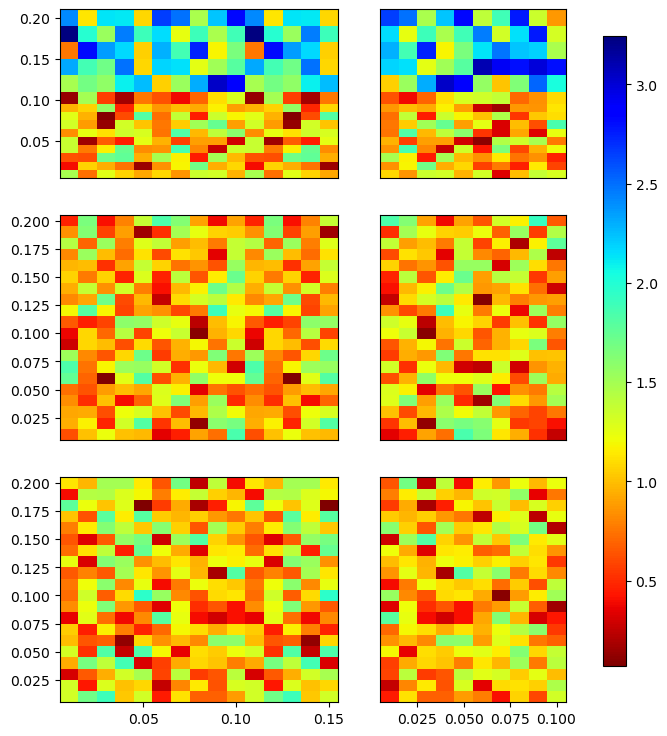

In [16]:
observable = get_spectrum(ells=(0, 2), size=20)
theory = get_spectrum(ells=(0, 2, 4), size=40)

from lsstypes import WindowMatrix

rng = np.random.RandomState(seed=42)
value = rng.uniform(0., 1., size=(observable.size, theory.size))
winmat = WindowMatrix(value=value, theory=theory, observable=observable)

# Main attributes
winmat.value()  # window array
assert winmat.value().shape == (observable.size, theory.size)

# To apply the window to a theory (ObservableLeaf, ObservableTree or numpy array)
array = winmat.dot(theory)  # returns a numpy array

# Let's say we want to select observed k in (0, 0.15); let's use the at syntax!
oshape = winmat.shape
winmat = winmat.at.observable.select(k=(0, 0.15))
assert np.all(winmat.observable.get(0).k < 0.15)
print(f'Old shape, new shape = {oshape}, {winmat.shape}')

# Let's further truncate the quadrupole to k < 0.1
winmat = winmat.at.observable.at(2).select(k=(0, 0.1))
assert np.all(winmat.observable.get(2).k < 0.1)

# We can also rebin, e.g. the theory:
winmat = winmat.at.theory.select(k=slice(0, None, 2))
# And rebin the hexadecapole theory further for k > 0.1
print(winmat.theory, winmat.shape)
winmat = winmat.at.theory.at(ells=4).at(k=(0.1, 1.)).select(k=slice(0, None, 2))
print(winmat.theory, winmat.shape)

# You can sum window matrices
winmat2 = winmat + winmat
assert np.allclose(winmat2.value(), winmat.value())


# Plot the matrix
winmat.plot(show=True);

## Covariance matrix

The covariance matrix quantifies the uncertainty on the measurement.

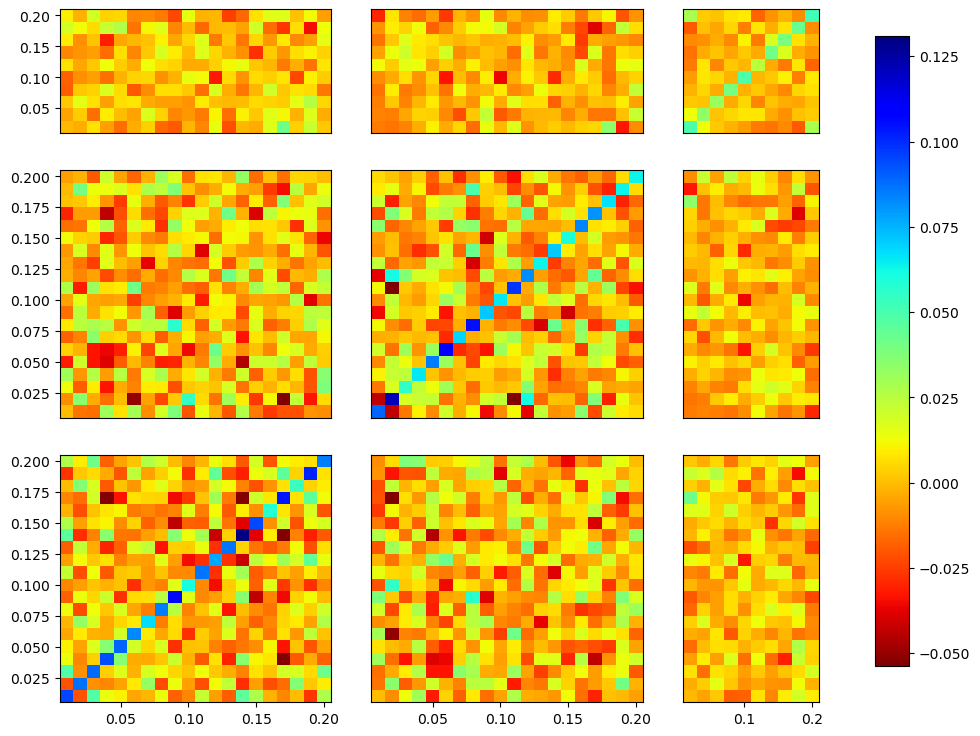

In [17]:
import lsstypes
from lsstypes import CovarianceMatrix

observable = get_spectrum(ells=(0, 2, 4), size=40)

rng = np.random.RandomState(seed=42)
value = rng.uniform(0., 1., size=(observable.size,) * 2)
covmat = CovarianceMatrix(value=value, observable=observable)

# Main attributes
covmat.value()  # covariance array
covmat.corrcoef()  # correlation array
covmat.std()  # standard deviation array

# You can also bin a covariance matrix from many realizations:
covmat = lsstypes.cov([get_spectrum(ells=(0, 2, 4), size=20, seed=seed) for seed in range(20)])

# You can rebin with the at syntax
covmat = covmat.at.observable.at(4).select(k=slice(0, 20, 2))

# And plot
covmat.plot(show=True);

## Gaussian Likelihood

One can build a Gaussian likelihood from the observed data, the window matrix and the covariance matrix.

In [18]:
from lsstypes import GaussianLikelihood

observable = get_spectrum(ells=(0, 2), size=40)
theory = get_spectrum(ells=(0, 2, 4), size=80)

rng = np.random.RandomState(seed=42)

value = rng.uniform(0., 1., size=(observable.size, theory.size))
winmat = WindowMatrix(value=value, observable=observable, theory=theory)
covmat = lsstypes.cov([get_spectrum(ells=(0, 2), size=40, seed=seed) for seed in range(20)])

likelihood = GaussianLikelihood(observable=observable, window=winmat, covariance=covmat)

# Main attributes
chi2 = likelihood.chi2(theory)  # return chi2 for the given input theory

# You can rebin with the at syntax
likelihood = likelihood.at.observable.at(2).select(k=slice(0, 20, 2))
assert likelihood.observable.size == likelihood.window.shape[0] == likelihood.covariance.shape[0]